In [1]:
import os

import pandas as pd
import numpy as np
import scipy 

import matplotlib.pyplot as plt

from MAGNN_preprocess_utils.preprocess import (
    get_column, 
    assign_index, 
    map_index_to_relation_file, 
    export_index2dat, 
    split_date,
    save_split_data2npz,
    generate_paths,
    get_metapath_adjacency_matrix,
    evaluate_metapath_adjacency_matrix,
    validate_expected_metapaths
)

# Input data preprocess

In [2]:
# list all file paths for the original relation .dat files
file_path = os.getcwd()
# file 1, 2: microbe-disease
file1 = os.path.join(file_path, "../data", "MAGNN_data", "disbiome_taxid_mondo.dat")
file2 = os.path.join(file_path, "../data", "MAGNN_data", "gmmad2_taxid_mondo.dat")
# file 3, 4: microbe-metabolite
file3 = os.path.join(file_path, "../data", "MAGNN_data", "gmmad2_taxid_met.dat")
file4 = os.path.join(file_path, "../data", "MAGNN_data", "hmdb_taxid_met.dat")
# file 5: metabolite-disease
file5 = os.path.join(file_path, "../data", "MAGNN_data", "hmdb_met_disease.dat")

In [3]:
# get entity columns individually
microbes1 = get_column(file1, colname1="Microbe", colname2="Disease", col="col1")
microbes2 = get_column(file2, colname1="Microbe", colname2="Disease", col="col1")
microbes3 = get_column(file3, colname1="Microbe", colname2="Metabolite", col="col1")
microbes4 = get_column(file4, colname1="Microbe", colname2="Metabolite", col="col1")
all_microbes = assign_index([microbes1, microbes2, microbes3, microbes4])

disease1 = get_column(file1, colname1="Microbe", colname2="Disease", col="col2")
disease2 = get_column(file2, colname1="Microbe", colname2="Disease", col="col2")
disease3 = get_column(file5, colname1="Metabolite", colname2="Disease", col="col2")
all_diseases = assign_index([disease1, disease2, disease3])

metabolite1 = get_column(file3, colname1="Microbe", colname2="Metabolite", col="col2")
metabolite2 = get_column(file4, colname1="Microbe", colname2="Metabolite", col="col2")
metabolite3 = get_column(file5, colname1="Metabolite", colname2="Disease", col="col1")
all_metabolites = assign_index([metabolite1, metabolite2, metabolite3])

In [4]:
# export index file to MKG_data_processing/MAGNN/data
export_index2dat(all_microbes, "data/microbe_index.dat")
export_index2dat(all_metabolites, "data/metabolite_index.dat")
export_index2dat(all_diseases, "data/disease_index.dat")

In [5]:
# merge two relation dfs together
md_merged_df = map_index_to_relation_file([file1, file2], "Microbe", "Disease", all_microbes, all_diseases)
mm_df = map_index_to_relation_file([file3, file4], "Microbe", "Metabolite", all_microbes, all_metabolites)
metd_df = map_index_to_relation_file([file5], "Metabolite", "Disease", all_metabolites, all_diseases)

In [6]:
# export relational dfs to .dat files
export_index2dat(md_merged_df, "data/microbe_disease_idx.dat")
export_index2dat(mm_df, "data/microbe_metabolite_idx.dat")
export_index2dat(metd_df, "data/metabolite_disease_idx.dat")

# Create adjacency matrix

In [7]:
save_prefix = "data/preprocessed/"

In [8]:
microbe_disease = pd.read_csv("data/microbe_disease_idx.dat", encoding='utf-8', delimiter='\t', names=['MicrobeIdx', 'DiseaseIdx'])
microbe_metabolite = pd.read_csv('data/microbe_metabolite_idx.dat', encoding='utf-8', delimiter='\t', names=['MicrobeIdx', 'MetaboliteIdx'])
metabolite_disease = pd.read_csv('data/metabolite_disease_idx.dat', encoding='utf-8', delimiter='\t', names=['MetaboliteIdx', 'DiseaseIdx'])
num_microbe = 8202
num_metabolite = 23823
num_disease = 898

### Check for duplicate relationships in the data
If duplicates exist, need to make increments when creating adjacency matrix 
<br>
Microbe-Disease and Microbe-Metabolite relationships have duplicates

In [9]:
# Check for duplicates in microbe_disease data
# if duplicates=True, need to make increments when creating adjM 
duplicates_in_microbe_disease = microbe_disease[microbe_disease.duplicated()]
print(duplicates_in_microbe_disease)

# Check for duplicates in microbe_metabolite data
duplicates_in_microbe_metabolite = microbe_metabolite[microbe_metabolite.duplicated()]
print(duplicates_in_microbe_metabolite)

# Check for duplicates in metabolite_disease data
duplicates_in_metabolite_disease = metabolite_disease[metabolite_disease.duplicated()]
print(duplicates_in_metabolite_disease)

        MicrobeIdx  DiseaseIdx
5083            62          48
5278            10         115
5504            92           8
7773           153          48
8396           498         187
...            ...         ...
501973         221          94
503661         182          40
504745           7          94
505352         247          29
505647         255           8

[527 rows x 2 columns]
        MicrobeIdx  MetaboliteIdx
598604          41            586
598635          41             45
598671          41            720
598714          41            772
598737          41            795
598774          41            675
598807          41            734
598833          41            125
598844          41            116
598854          41            600
598855          49           1412
598858          41            988
598895         177            309
598913          41            260
598921         177            118
598943          41            976
598995          41        

# Split data into training, validation, and testing sets

In [10]:
md_train, md_val, md_test = split_date(microbe_disease, train_ratio=0.7, val_ratio=0.2, test_ratio=0.1)
# save_split_data2npz(md_train, md_val, md_test, "data/micro_disease_train_val_test_idx.npz")

In [11]:
# training: 70%, validation: 20%, testing: 10%
train_val_test_idx = np.load("data/micro_disease_train_val_test_idx.npz")
train_idx = train_val_test_idx['train']
val_idx = train_val_test_idx['val']
test_idx = train_val_test_idx['test']

# reset microbe-disease index 
microbe_disease = microbe_disease.loc[train_idx].reset_index(drop=True)
microbe_disease.head()
print(f"Length of Training data: {len(microbe_disease)}")

Length of Training data: 354096


In [12]:
# build adjacency matrix
# 0 for microbe, 1 for disease, 2 for metabolite
dim = num_microbe + num_disease + num_metabolite

type_mask = np.zeros(dim, dtype=int)
type_mask[num_microbe:num_microbe+num_disease] = 1
type_mask[num_microbe+num_disease:]=2

adjM = np.zeros((dim, dim), dtype=int)
for _, row in microbe_disease.iterrows():
    microID = row["MicrobeIdx"]
    diseaseID = num_microbe + row["DiseaseIdx"]
    # increment accounts for multiple links exist between same microbe and disease relationships
    adjM[microID, diseaseID] += 1
    adjM[diseaseID, microID] += 1
for _, row in microbe_metabolite.iterrows():
    microID = row["MicrobeIdx"]
    metID = num_microbe + num_disease + row["MetaboliteIdx"]
    adjM[microID, metID] += 1
    adjM[metID, microID] += 1
for _, row in metabolite_disease.iterrows():
    metID = num_microbe + num_disease + row["MetaboliteIdx"]
    diseaseID = num_microbe + row["DiseaseIdx"]
    adjM[metID, diseaseID] = 1
    adjM[diseaseID, metID] = 1

#### Check for non-zero entries in the adjacency matrix

In [13]:
# example of non-zero entries in the adjacency matrix
adjM[8202:8212, 0:10]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 1, 0, 1, 0, 1, 1, 1, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 2, 0, 0, 1, 0, 1, 1, 2, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1]])

## Metapath Analysis

In [14]:
# TODO: Ways to summarize and compare the non-zero metapath adjacency matrix?

### Path count analysis
- sum of all values of each metapath type adjM (total path count)
- max value of node pair 
- average path count per node pair (mean_node_pair) <br> `metapath_adjM.sum() / (metapath_adjM.shape[0] * metapath_adjM.shape[1]`)
- min value of node pair in non-zero metapath adjM
- mean value of node pair in non-zero metapath adjM
- **desnity** is used for plots (proportion of non-zero node pairs in the graph network have at least one path along the metapath) <br> `np.count_nonzero(metapath_adjM) / (metapath_adjM[0] * metapath_adjM[1])`

In [15]:
expected_metapath_l3 = generate_paths(3)
metapath_len3 = evaluate_metapath_adjacency_matrix(adjM, type_mask, expected_metapath_l3)
metapath_len3_df = pd.DataFrame(metapath_len3)
metapath_len3_df

,metapath,sum,max,min,mean,density,non_zero_mean
0,"(0, 1, 0)",1511417774,127,1,22.466995,0.666652,33.701239
1,"(0, 1, 2)",3130452,10,1,0.016021,0.012036,1.331122
2,"(0, 2, 0)",384891158,1011,1,5.721349,0.015410,371.274302
3,"(0, 2, 1)",1497403,159,1,0.203302,0.042238,4.813284
4,"(1, 0, 1)",20477412,4555,1,25.393490,0.073259,346.628275
5,"(1, 0, 2)",2037517,48,1,0.095242,0.006567,14.502210
6,"(1, 2, 0)",1497403,159,1,0.203302,0.042238,4.813284
7,"(1, 2, 1)",92218,20017,1,0.114357,0.035901,3.185313
8,"(2, 0, 1)",2037517,48,1,0.095242,0.006567,14.502210
9,"(2, 0, 2)",437895926,906,1,0.771575,0.003860,199.866325


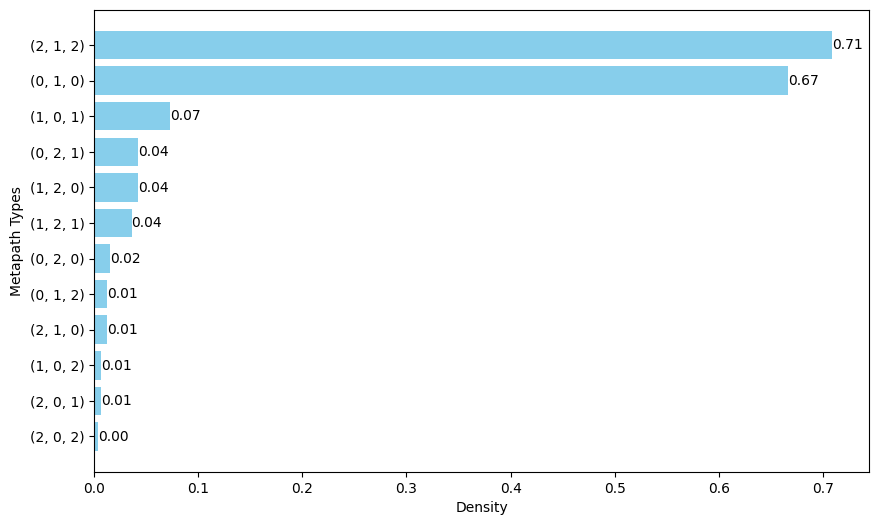

In [16]:
sorted_metapath_len3_df = metapath_len3_df.sort_values(by='density', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(sorted_metapath_len3_df['metapath'].astype(str), sorted_metapath_len3_df['density'], color='skyblue')
plt.xlabel('Density')
plt.ylabel('Metapath Types')
plt.gca().invert_yaxis()
for index, value in enumerate(sorted_metapath_len3_df['density']):
    plt.text(value, index, f'{value:.2f}', va='center')
plt.show()

In [17]:
possible_metapath_l4 = generate_paths(4)
# [1, 0, 0, 1] # this metapath does not exist, output is 0
metapath_len4 = evaluate_metapath_adjacency_matrix(adjM, type_mask, possible_metapath_l4)
metapath_len4_df = pd.DataFrame(metapath_len4)
metapath_len4_df

,metapath,sum,max,min,mean,density,non_zero_mean
0,"(0, 1, 0, 1)",87378481671,220828,1,11863.378652,0.305117,38881.417479
1,"(0, 1, 0, 2)",8617642322,2882,1,44.103418,0.050887,866.685620
2,"(0, 1, 2, 0)",720340179,567,1,10.707747,0.107305,99.787564
3,"(0, 1, 2, 1)",30812936,1372,1,4.183473,0.327643,12.768375
4,"(0, 2, 0, 1)",1291057169,26202,1,175.286864,0.030379,5770.010543
5,"(0, 2, 0, 2)",280142588214,562988,1,1433.715304,0.010019,143093.646563
6,"(0, 2, 1, 0)",720340179,567,1,10.707747,0.107305,99.787564
7,"(0, 2, 1, 2)",232975416,1250,1,1.192323,0.101054,11.798923
8,"(1, 0, 1, 0)",87378481671,220828,1,11863.378652,0.305117,38881.417479
9,"(1, 0, 1, 2)",179942168,19757,1,8.411243,0.015932,527.937355


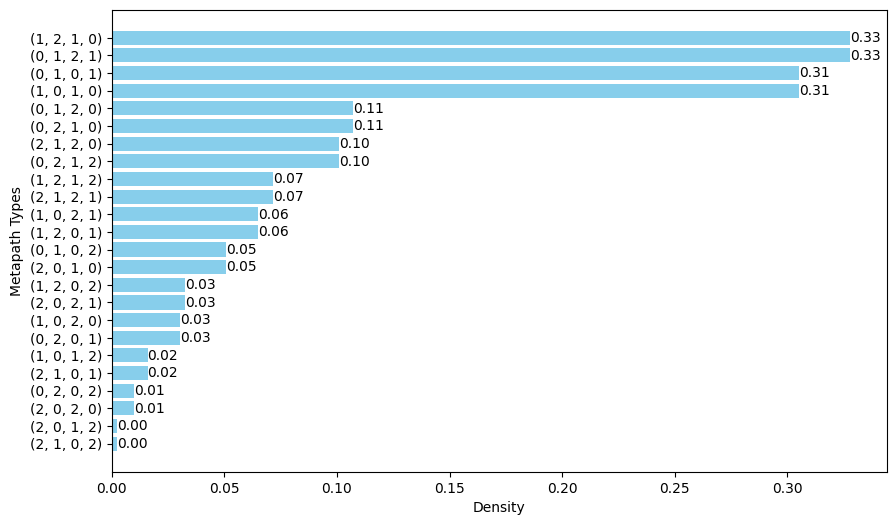

In [18]:
sorted_metapath_len4_df = metapath_len4_df.sort_values(by='density', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(sorted_metapath_len4_df['metapath'].astype(str), sorted_metapath_len4_df['density'], color='skyblue')
plt.xlabel('Density')
plt.ylabel('Metapath Types')
plt.gca().invert_yaxis()
for index, value in enumerate(sorted_metapath_len4_df['density']):
    plt.text(value, index, f'{value:.2f}', va='center')
plt.show()

In [19]:
possible_metapath_l5 = generate_paths(5)
metapath_len5 = evaluate_metapath_adjacency_matrix(adjM, type_mask, possible_metapath_l5)
metapath_len5_df = pd.DataFrame(metapath_len5)
metapath_len5_df

,metapath,sum,max,min,mean,density,non_zero_mean
0,"(0, 1, 0, 1, 0)",373505335288170,15636599,1,5.552100e+06,0.720875,7.701892e+06
1,"(0, 1, 0, 1, 2)",766097357510,1312682,1,3.920737e+03,0.044332,8.843993e+04
2,"(0, 1, 0, 2, 0)",5466549836744,1616731,1,8.125943e+04,0.132775,6.120077e+05
3,"(0, 1, 0, 2, 1)",22938073139,318156,1,3.114303e+03,0.402284,7.741553e+03
4,"(0, 1, 2, 0, 1)",2664001128,19840,1,3.616915e+02,0.181575,1.991964e+03
5,"(0, 1, 2, 0, 2)",503288369903,379918,1,2.575732e+03,0.054692,4.709512e+04
6,"(0, 1, 2, 1, 0)",26273662086,5797,1,3.905540e+02,0.606926,6.434957e+02
7,"(0, 1, 2, 1, 2)",4630636545,9349,1,2.369870e+01,0.656013,3.612535e+01
8,"(0, 2, 0, 1, 0)",5466549836744,1616731,1,8.125943e+04,0.132775,6.120077e+05
9,"(0, 2, 0, 1, 2)",12541309171,144695,1,6.418398e+01,0.007818,8.209522e+03


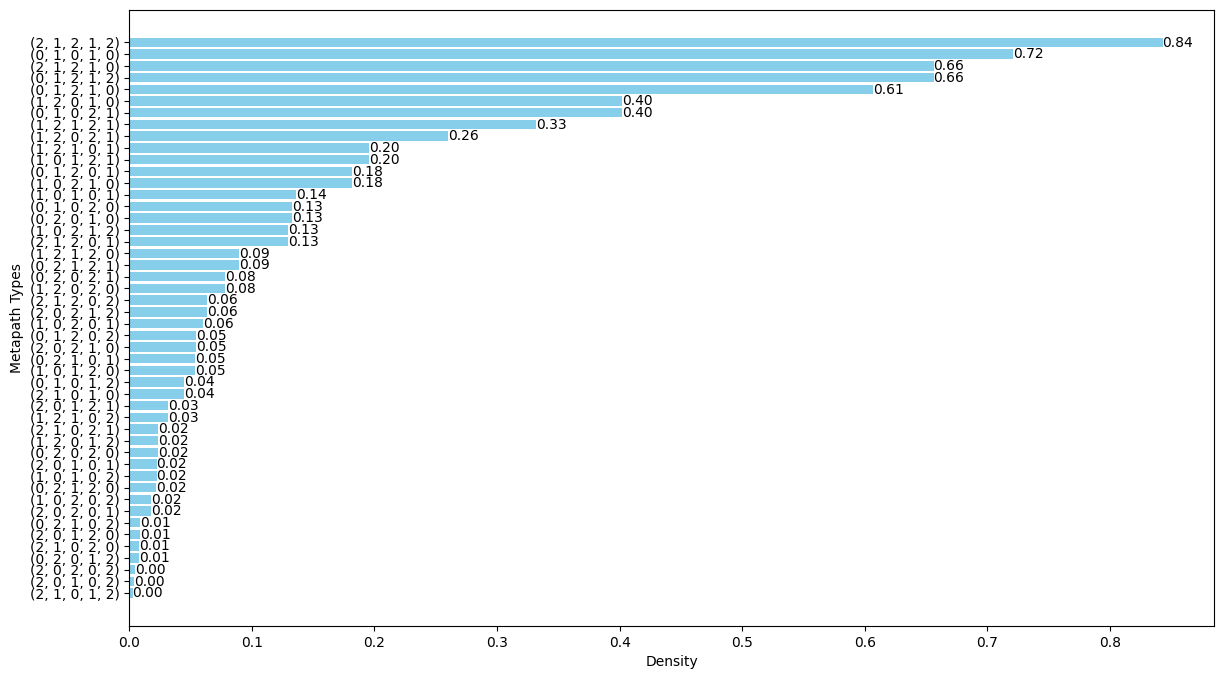

In [20]:
sorted_metapath_len5_df = metapath_len5_df.sort_values(by='density', ascending=False)

plt.figure(figsize=(14, 8))
plt.barh(sorted_metapath_len5_df['metapath'].astype(str), sorted_metapath_len5_df['density'], color='skyblue')
plt.xlabel('Density')
plt.ylabel('Metapath Types')
plt.gca().invert_yaxis()
for index, value in enumerate(sorted_metapath_len5_df['density']):
    plt.text(value, index, f'{value:.2f}', va='center')
plt.show()

In [21]:
possible_metapath_l6 = generate_paths(6)
metapath_len6 = evaluate_metapath_adjacency_matrix(adjM, type_mask, possible_metapath_l6)
metapath_len6_df = pd.DataFrame(metapath_len6)
metapath_len6_df

,metapath,sum,max,min,mean,density,non_zero_mean
0,"(0, 1, 0, 1, 0, 1)",21594714963230301,54532565870,1,2.931915e+09,0.313933,9.339289e+09
1,"(0, 1, 0, 1, 0, 2)",2129543727675288,709704353,1,1.089859e+07,0.051606,2.111871e+08
2,"(0, 1, 0, 1, 2, 0)",176728212808525,54092581,1,2.627038e+06,0.126909,2.070022e+07
3,"(0, 1, 0, 1, 2, 1)",7560032268916,113272263,1,1.026426e+06,0.478103,2.146872e+06
4,"(0, 1, 0, 2, 0, 1)",19285154463505,55498815,1,2.618346e+06,0.226380,1.156614e+07
...,...,...,...,...,...,...,...
91,"(2, 1, 2, 0, 2, 1)",396193403504,97370734,1,1.851972e+04,0.488482,3.791281e+04
92,"(2, 1, 2, 1, 0, 1)",266435622385,14816466,1,1.245431e+04,0.346745,3.591779e+04
93,"(2, 1, 2, 1, 0, 2)",29373918635,188620,1,5.175699e+01,0.056875,9.100099e+02
94,"(2, 1, 2, 1, 2, 0)",668225198824,1415947,1,3.419847e+03,0.138572,2.467929e+04


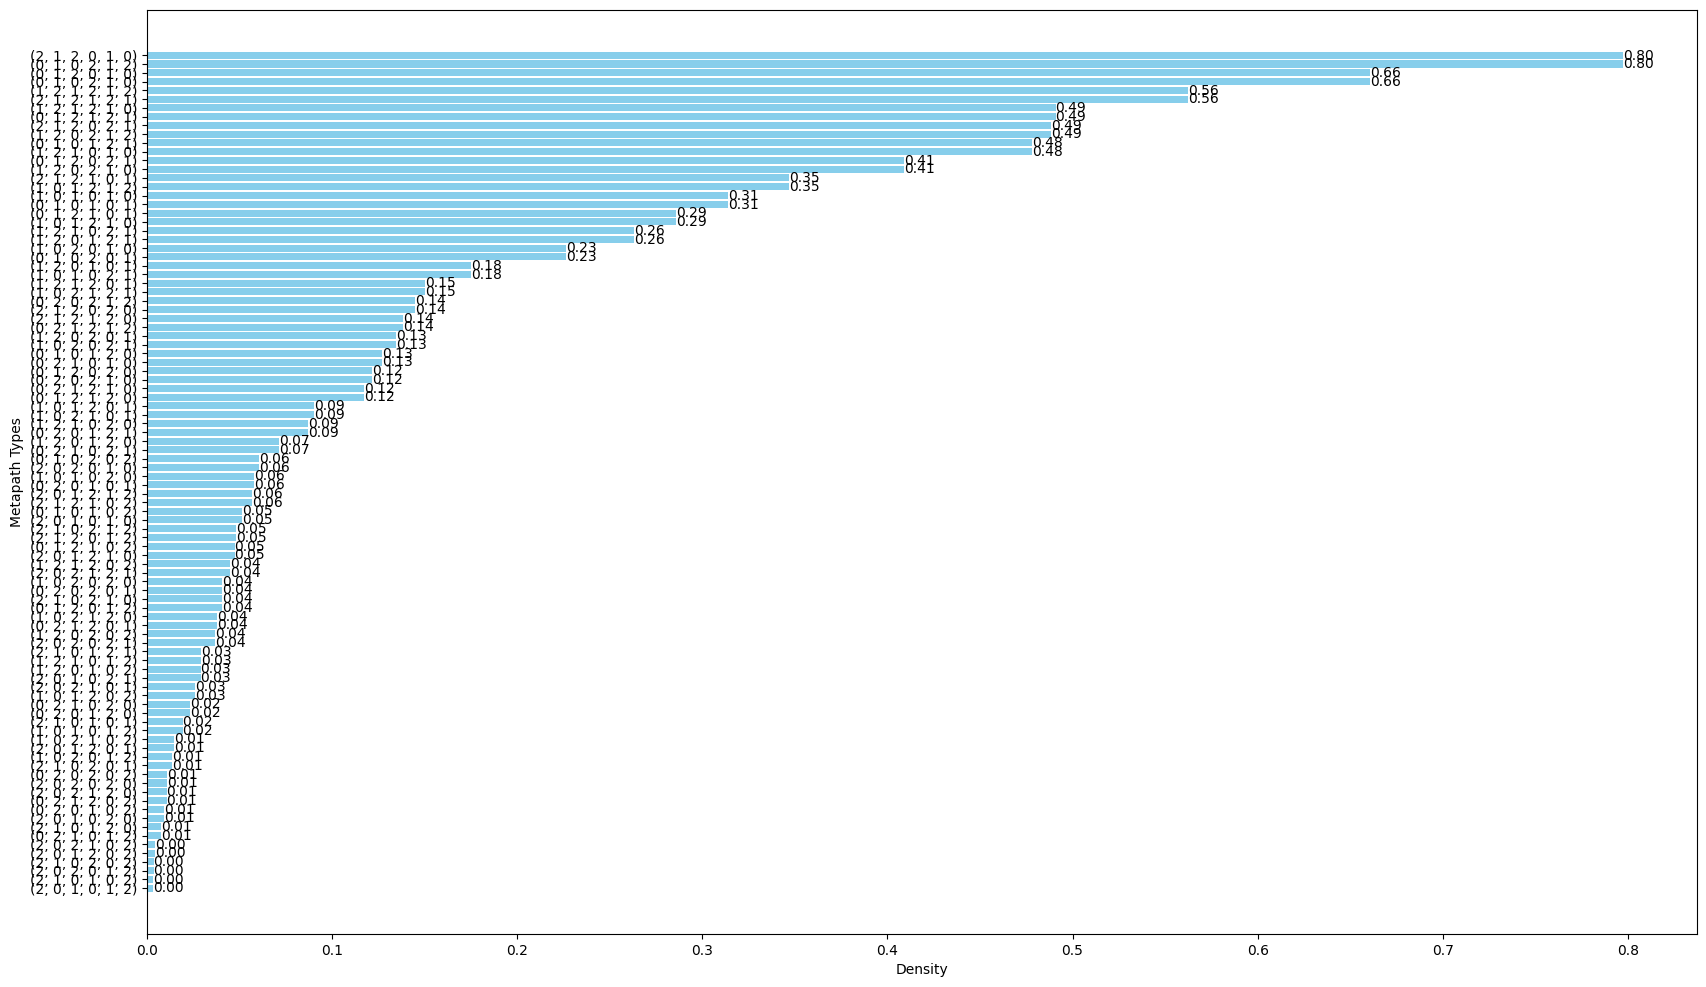

In [22]:
sorted_metapath_len6_df = metapath_len6_df.sort_values(by='density', ascending=False)

plt.figure(figsize=(20, 12))
plt.barh(sorted_metapath_len6_df['metapath'].astype(str), sorted_metapath_len6_df['density'], color='skyblue')
plt.xlabel('Density')
plt.ylabel('Metapath Types')
plt.gca().invert_yaxis()
for index, value in enumerate(sorted_metapath_len6_df['density']):
    plt.text(value, index, f'{value:.2f}', va='center')
plt.show()

In [32]:
expected_metapaths = [(0, 1, 0), (1, 0, 1), (0, 2, 0), (2, 0, 2), (1, 2, 1), (2, 1, 2), 
                      (0, 1, 2, 1, 0), (1, 0, 2, 0, 1), (0, 2, 1, 2, 0), (1, 2, 0, 2, 1)]
validate_expected_metapaths(possible_metapath_l4, expected_metapaths)
validate_expected_metapaths(possible_metapath_l5, expected_metapaths)

Metapath types have all expected triple combinations!
Metapath types have all expected triple combinations!


# Continue for adjacency Matrix

In [24]:
# map each microbe to a list of diseases
microbe_disease_list = {i: adjM[i, num_microbe:num_microbe+num_disease].nonzero()[0] for i in range(num_microbe)}
# map each disease to a list of microbes
disease_microbe_list = {i: adjM[num_microbe+i, :num_microbe].nonzero()[0] for i in range(num_disease)}
# map each metabolite to a list of diseases
metabolite_disease_list = {i: adjM[num_microbe+num_disease+i, num_microbe:num_microbe+num_disease].nonzero()[0] for i in range(num_metabolite)}
# map each disease to a list of metabolites
disease_metabolite_list = {i: adjM[num_microbe+i, num_microbe+num_disease:num_microbe+num_disease+num_metabolite].nonzero()[0] for i in range(num_disease)}
# map each microbe to a list of metabolites
microbe_metabolite_list = {i: adjM[i, num_microbe+num_disease:num_microbe+num_disease+num_metabolite].nonzero()[0] for i in range(num_microbe)}
# map each metabolite to a list of microbes
metabolite_microbe_list = {i: adjM[num_microbe+num_disease+i, :num_microbe].nonzero()[0] for i in range(num_metabolite)}